# Pylops - MDD with cupy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.seismicevents import *
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.mdd import *
from pylops.optimization.basic import cgls

/home/ravasim/miniconda3_v23/envs/pylops_cupy_3090/lib/python3.9/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
###### Input parameters
par = {'ox':-600,  'dx':10,    'nx':121,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1400.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

# Create taper for operator
tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
#G,Gwav = hyperbolic3d(x,y,t,t0_G,vrms_G,vrms_G,amp_G,wav)
G,Gwav = np.zeros((par['ny'],par['nx'],par['nt'])), np.zeros((par['ny'],par['nx'],par['nt']))
for iy,y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwav = G*tap,Gwav*tap

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)), m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

## Single virtual source

In [3]:
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

# numpy
MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], 
          twosided=True)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True);

# cupy
MDCop_cp=MDC(cp.array(Gwav_fft.transpose(2,0,1)), nt=2*par['nt']-1, nv=1, 
             dt=par['dt'], dr=par['dx'], twosided=True)
dottest(MDCop_cp, MDCop_cp.shape[0], MDCop_cp.shape[1], complexflag=3, verb=True, backend='cupy');

Dot test passed, v^H(Opu)=470.0249988734141 - u^H(Op^Hv)=470.0249988733992
Dot test passed, v^H(Opu)=-503.43601931778403 - u^H(Op^Hv)=-503.43601931777994


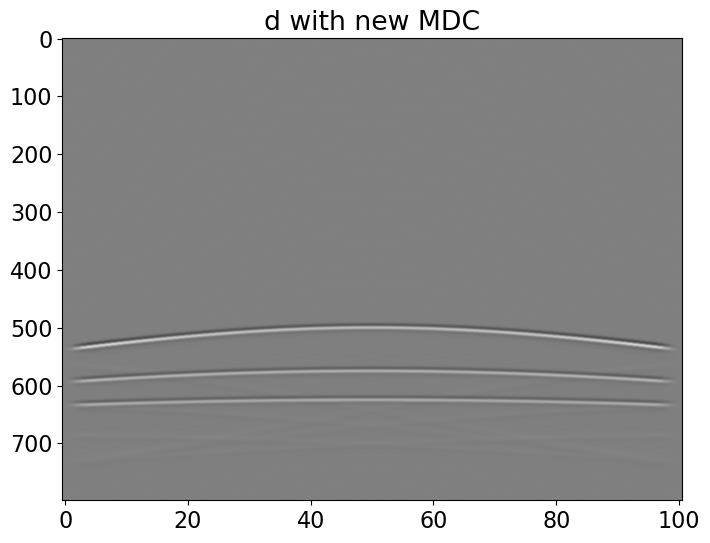

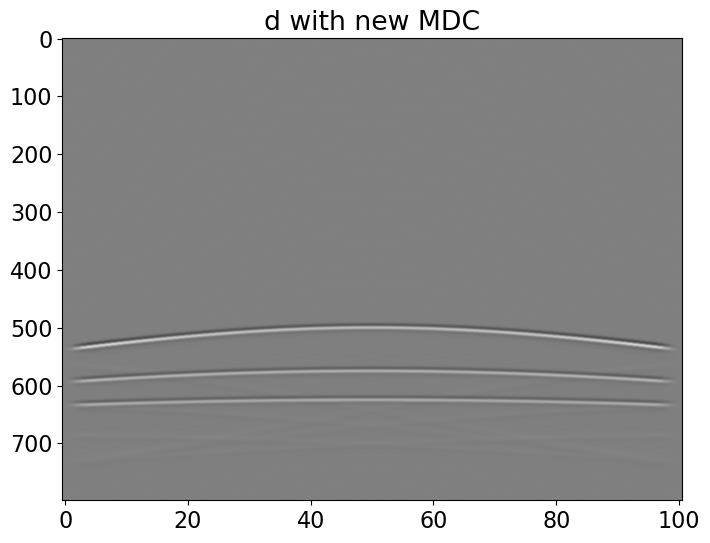

In [4]:
# Create data
d = MDCop*m.T.flatten()
d = d.reshape(2*par['nt']-1, par['ny'])

m_cp = cp.array(m)
d_cp = MDCop_cp*m_cp.T.flatten()
d_cp = d_cp.reshape(2*par['nt']-1, par['ny'])

plt.figure()
plt.imshow(d, vmin=-20, vmax=20, cmap='gray')
plt.title('d with new MDC')
plt.axis('tight')

plt.figure()
plt.imshow(cp.asnumpy(d_cp), vmin=-20, vmax=20, cmap='gray')
plt.title('d with new MDC')
plt.axis('tight');

In [5]:
# Adjoint and inverse (numpy)
madj = MDCop.H*d.flatten()
minv = cgls(MDCop, d.ravel(), x0=np.zeros_like(m).ravel(), damp=1e-10, niter=10, show=1)[0]

madj = madj.reshape(2*par['nt']-1, par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'])

# Adjoint and inverse (cupy)
madj_cp = MDCop_cp.H*d_cp.flatten()
minv_cp = cgls(MDCop_cp, d_cp.ravel(), x0=cp.zeros_like(m_cp).ravel(), damp=1e-10, niter=10, show=1)[0]

madj_cp = madj_cp.reshape(2*par['nt']-1, par['nx'])
minv_cp = minv_cp.reshape(2*par['nt']-1, par['nx'])

CGLS
-----------------------------------------------------------------
The Operator Op has 80699 rows and 96679 cols
damp = 1.000000e-20	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         1.8246e+02     1.8246e+02
     2        0.0000e+00         1.2989e+02     1.2989e+02
     3        0.0000e+00         1.0124e+02     1.0124e+02
     4        0.0000e+00         8.4741e+01     8.4741e+01
     5        0.0000e+00         7.1419e+01     7.1419e+01
     6        0.0000e+00         6.0501e+01     6.0501e+01
     7        0.0000e+00         5.2852e+01     5.2852e+01
     8        0.0000e+00         4.6752e+01     4.6752e+01
     9        0.0000e+00         4.1485e+01     4.1485e+01
    10        0.0000e+00         3.7278e+01     3.7278e+01

Iterations = 10        Total time (s) = 0.59
-----------------------------------------------------------------

CGLS
-

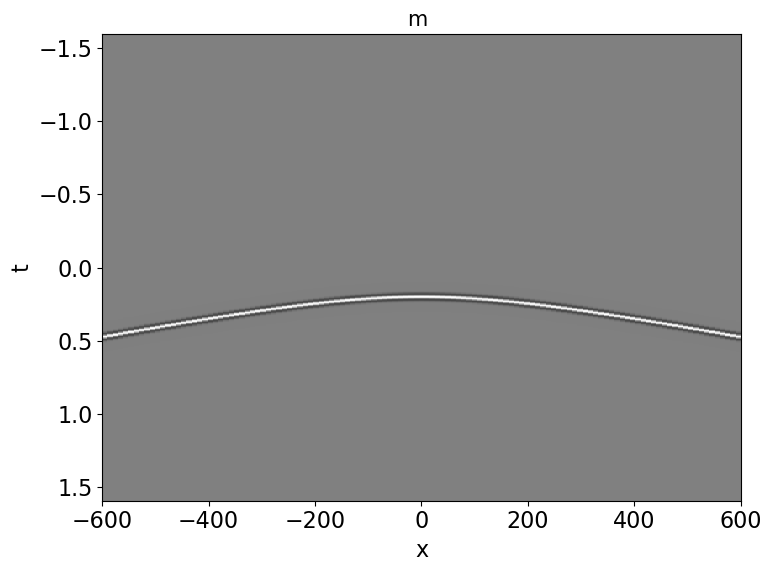

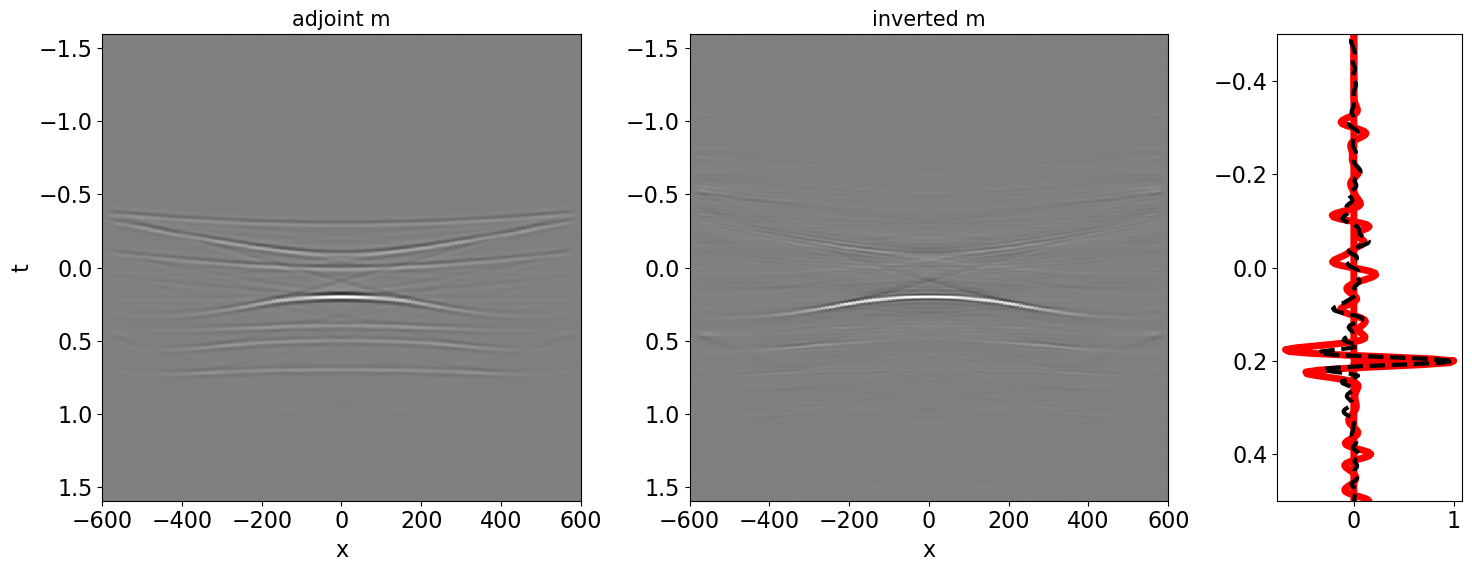

In [6]:
# Plotting numpy results
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(m[int(par['nx']/2)]/np.abs(m[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(madj[:, int(par['nx']/2)]/np.abs(madj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(par['nx']/2)]/np.abs(minv[:, int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim(0.5, -0.5)
fig.tight_layout()

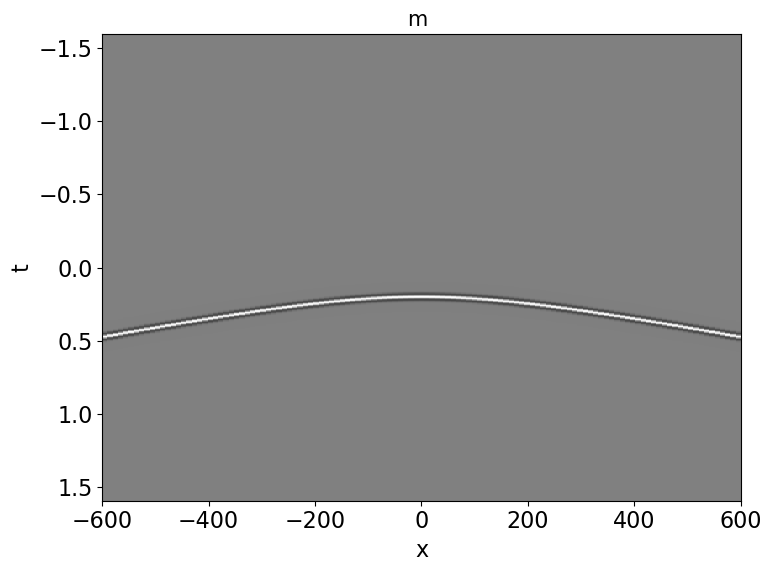

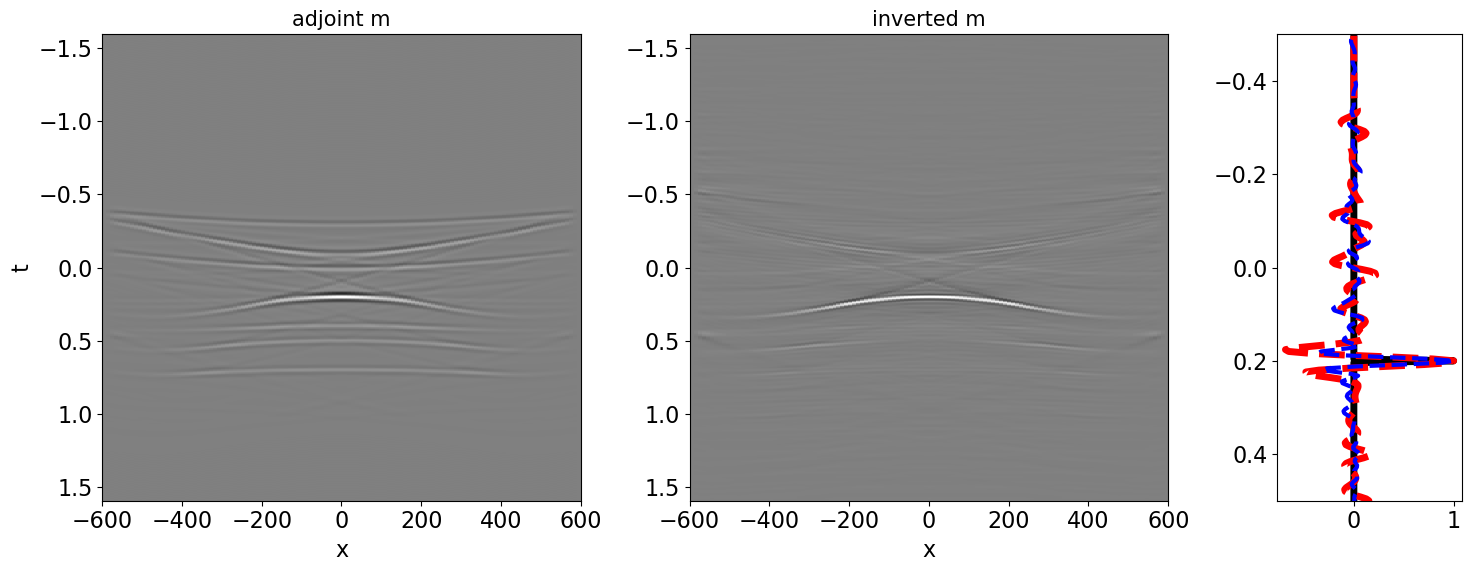

In [7]:
# Plotting cupy results
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(cp.asnumpy(madj_cp), aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj_cp.max(), vmax=madj_cp.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(cp.asnumpy(minv_cp), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv_cp.max(), vmax=minv_cp.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(cp.asnumpy(m[int(par['nx']/2)])/cp.asnumpy(np.abs(m[int(par['nx']/2)]).max()), t2, 'k', lw=5)
ax3.plot(cp.asnumpy(madj_cp[:, int(par['nx']/2)])/cp.asnumpy(np.abs(madj_cp[:, int(par['nx']/2)]).max()), t2, '--r', lw=5)
ax3.plot(cp.asnumpy(minv_cp[:, int(par['nx']/2)])/cp.asnumpy(np.abs(minv_cp[:, int(par['nx']/2)]).max()), t2, '--b', lw=3)
ax3.set_ylim(0.5, -0.5)
fig.tight_layout()

In [8]:
# Invert for model (numpy)
minv,madj = MDD(Gwav2, d.T, 
                dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                twosided=True, add_negative=False, smooth_precond=10,
                adjoint=True, psf=False, dottest=True, 
                **dict(damp=1e-4, iter_lim=30, show=1))

Dot test passed, v^H(Opu)=8222.163203669867 - u^H(Op^Hv)=8222.16320366986
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 80699 rows and 96679 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.151e+02  3.151e+02    1.0e+00  4.8e-01
     1  0.00000e+00   1.825e+02  1.825e+02    5.8e-01  6.6e-01   1.9e+02  1.0e+00
     2  0.00000e+00   1.299e+02  1.299e+02    4.1e-01  3.4e-01   2.7e+02  2.2e+00
     3  0.00000e+00   1.012e+02  1.012e+02    3.2e-01  2.6e-01   3.2e+02  3.7e+00
     4  0.00000e+00   8.474e+01  8.474e+01    2.7e-01  2.1e-01   3.8e+02  5.3e+00
     5  0.00000e+00   7.142e+01  7.142e+01    2.3e-01  1.7e-01   4.2e+02  7.2e+00
     6  0.00000e+00   6.050e+01  6.050e+01    1.9e-01  1.6e-01   4.6e+02  9.2e+00
     7  0.00000e+00   5.285e+01  5.285e+

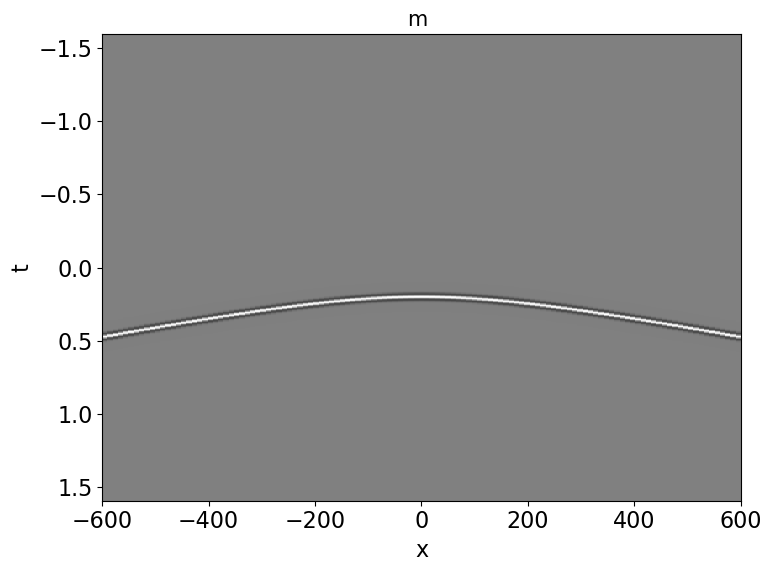

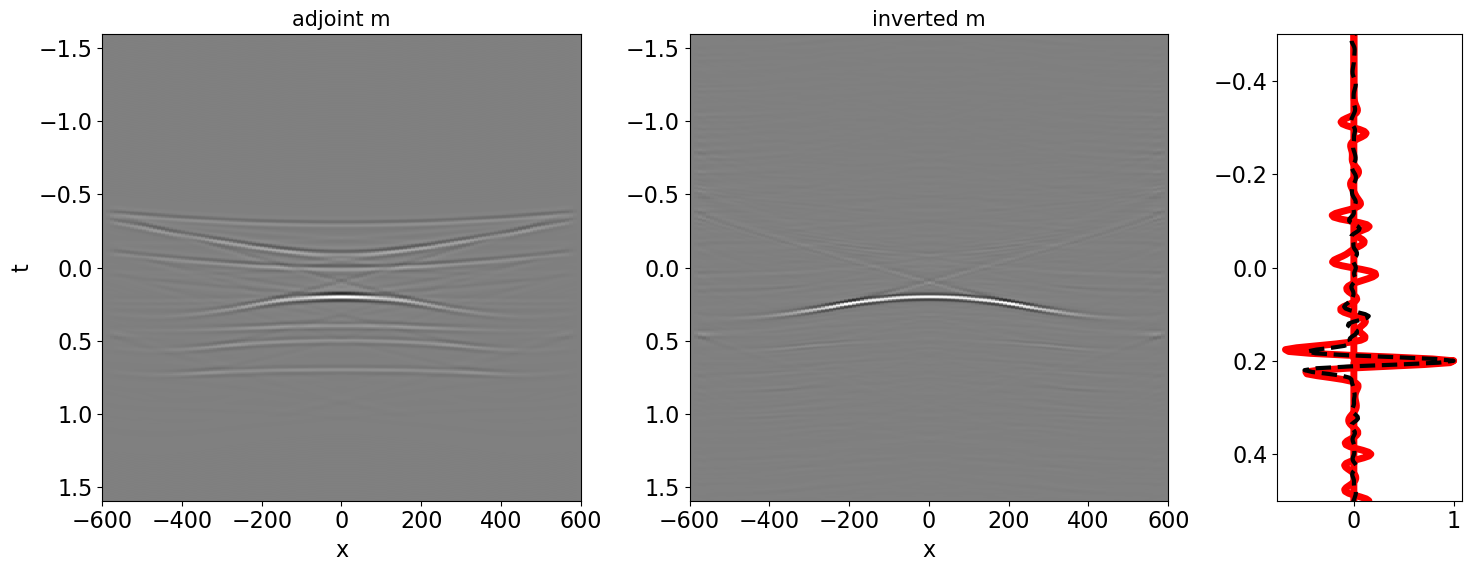

In [9]:
plt.figure()
plt.imshow(mwav.T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(m[int(par['nx']/2)]/np.abs(m[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim(0.5, -0.5)
fig.tight_layout()

In [10]:
# Invert for model (cupy)
minv,madj = MDD(cp.array(Gwav2), cp.array(d).T, 
                dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], 
                wav = cp.array(wav), twosided=True, add_negative=False, smooth_precond=10,
                adjoint=True, psf=False, dottest=True, 
                **dict(damp=1e-4, niter=30, show=1))

Dot test passed, v^H(Opu)=-2203.977630118703 - u^H(Op^Hv)=-2203.977630118715
CGLS
-----------------------------------------------------------------
The Operator Op has 80699 rows and 96679 cols
damp = 1.000000e-08	tol = 1.000000e-04	niter = 30
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -4.6250e-20         1.8246e+02     1.8246e+02
     2       -1.1254e-19         1.2989e+02     1.2989e+02
     3       -1.3492e-19         1.0124e+02     1.0124e+02
     4       -1.1881e-19         8.4741e+01     8.4741e+01
     5       -9.0279e-20         7.1419e+01     7.1419e+01
     6       -5.4904e-20         6.0501e+01     6.0501e+01
     7       -2.1451e-20         5.2852e+01     5.2852e+01
     8        2.0019e-20         4.6752e+01     4.6752e+01
     9        5.8821e-20         4.1485e+01     4.1485e+01
    10        8.3836e-20         3.7278e+01     3.7278e+01
    11        1.0406e-19         3.3959e+0

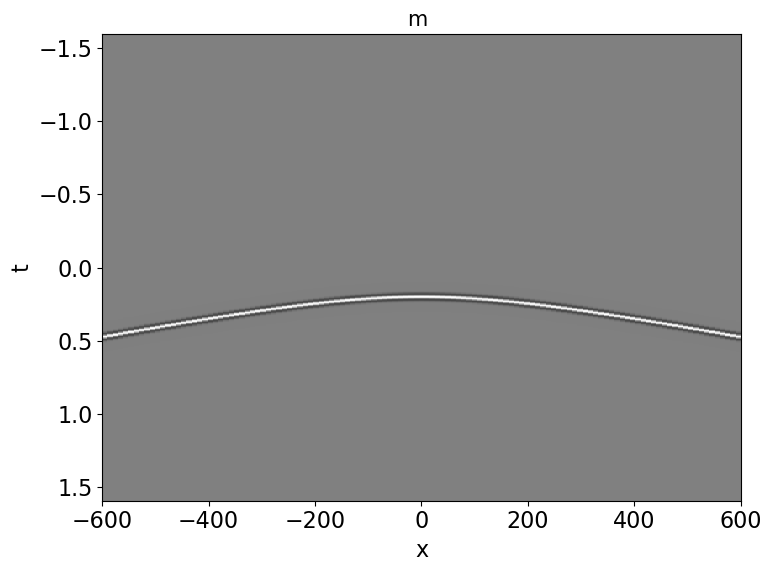

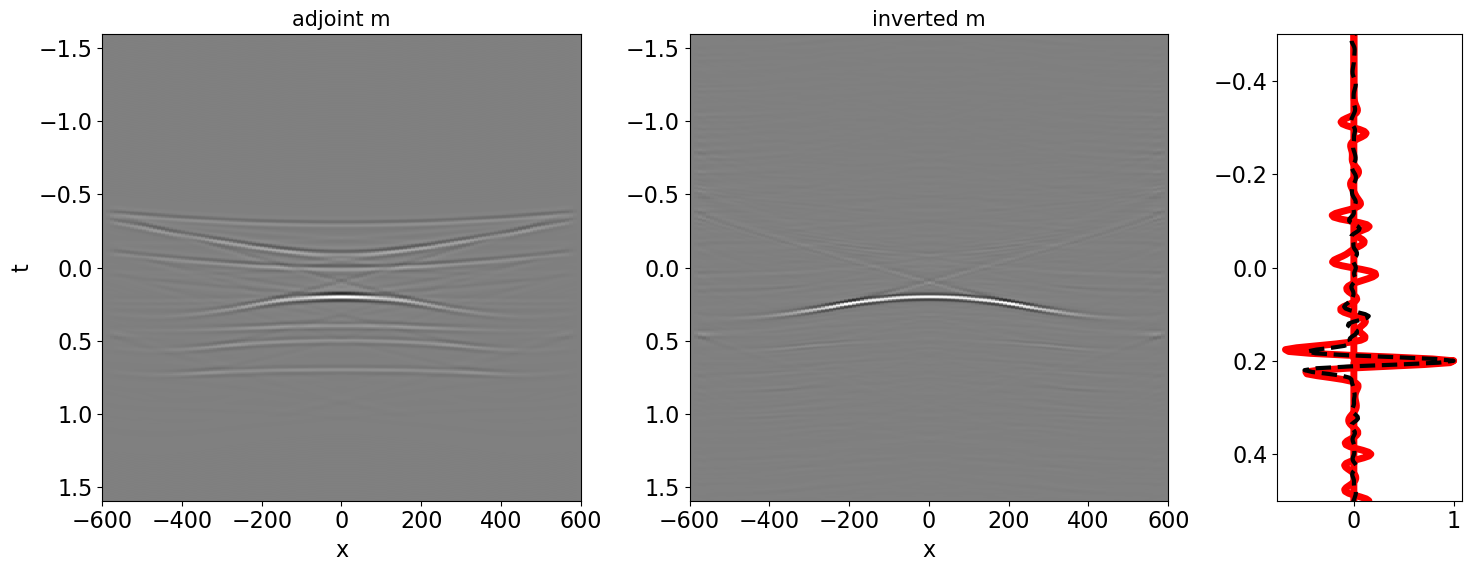

In [11]:
plt.figure()
plt.imshow(mwav.T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(cp.asnumpy(madj).T, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(cp.asnumpy(minv).T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(m[int(par['nx']/2)]/np.abs(m[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(cp.asnumpy(madj)[int(par['nx']/2)]/np.abs(cp.asnumpy(madj)[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(cp.asnumpy(minv)[int(par['nx']/2)]/np.abs(cp.asnumpy(minv)[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim(0.5, -0.5)
fig.tight_layout()

## Multiple virtual sources

In [12]:
# Generate model
m, mwav =  hyperbolic3d(x,x,t,t0_m,vrms_m,vrms_m,amp_m,wav)
m, mwav = np.zeros((par['nx'],par['nx'],par['nt'])), np.zeros((par['nx'],par['nx'],par['nt']))
for ix,x0 in enumerate(x):
    m[ix],mwav[ix] = hyperbolic2d(x-x0,t,t0_m,vrms_m,amp_m,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)), mwav), axis=-1)

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1,
          nv=par['nx'], dt=par['dt'], dr=par['dx'], 
          twosided=True)
MDCop_cp=MDC(cp.array(Gwav_fft).transpose(2,0,1), nt=2*par['nt']-1,
             nv=par['nx'], dt=par['dt'], dr=par['dx'], 
             twosided=True)
dottest(MDCop, (2*par['nt']-1)*par['nx']*par['ny'],(2*par['nt']-1)*par['nx']*par['nx'], verb=True);

Dot test passed, v^H(Opu)=28792.428564695383 - u^H(Op^Hv)=28792.428564694812


In [13]:
# Create data
d = MDCop*m.transpose(2,0,1).flatten()
d = d.reshape(2*par['nt']-1, par['ny'], par['nx'])

# Invert for model (numpy)
minv,madj,psfinv,psfadj = MDD(Gwav2, d.transpose(1, 2, 0), dt=par['dt'], dr=par['dx'], 
                              nfmax=par['nfmax'], twosided=True, wav=wav, causality_precond=True,
                              adjoint=True, add_negative=False, psf=True, dottest=True, 
                              **dict(damp=1e-10, iter_lim=30, show=1))

Dot test passed, v^H(Opu)=-40372.26502341531 - u^H(Op^Hv)=-40372.26502341555
Dot test passed, v^H(Opu)=83787.50476205509 - u^H(Op^Hv)=83787.50476205612
PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 9764579 rows and 11698159 cols
Prec=<11698159x11698159 Diagonal with dtype=float64>
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 9764579 rows and 11698159 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.991e+03  3.991e+03    1.0e+00  3.2e-02
     1  0.00000e+00   2.359e+03  2.359e+03    5.9e-01  7.5e-01   1.6e+02  1.0e+00
     2  0.00000e+00   1.616e+03  1.616e+03    4.0e-01  4.3e-01   2.5e+02  2.3e+00
     3  0.00000e+00   1.1

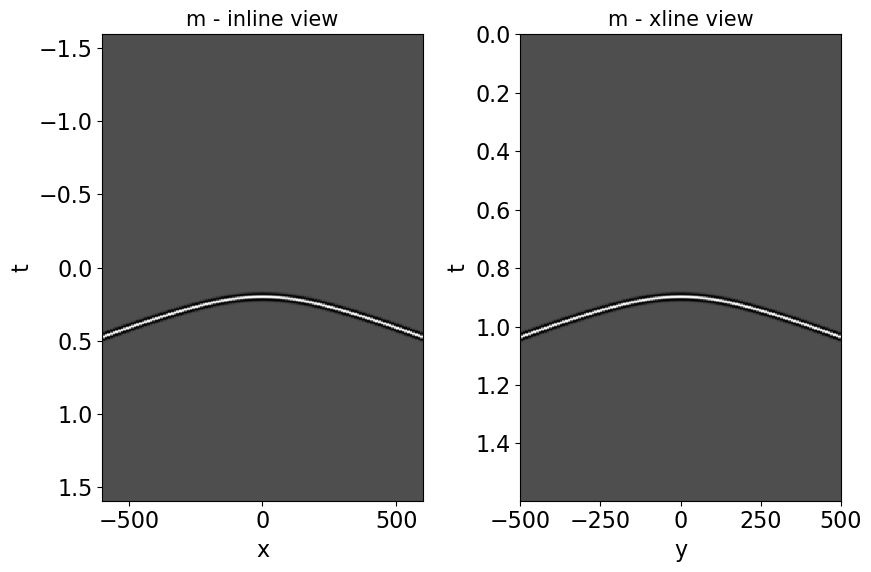

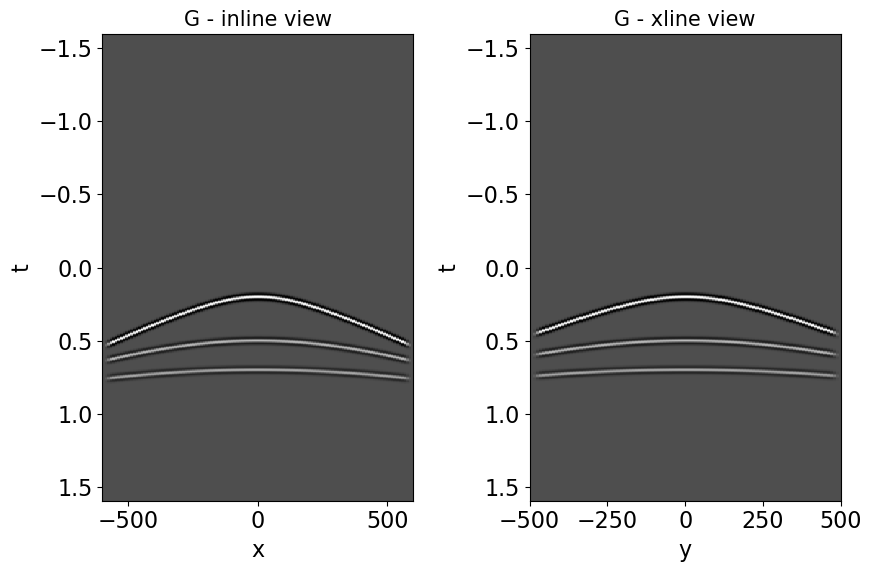

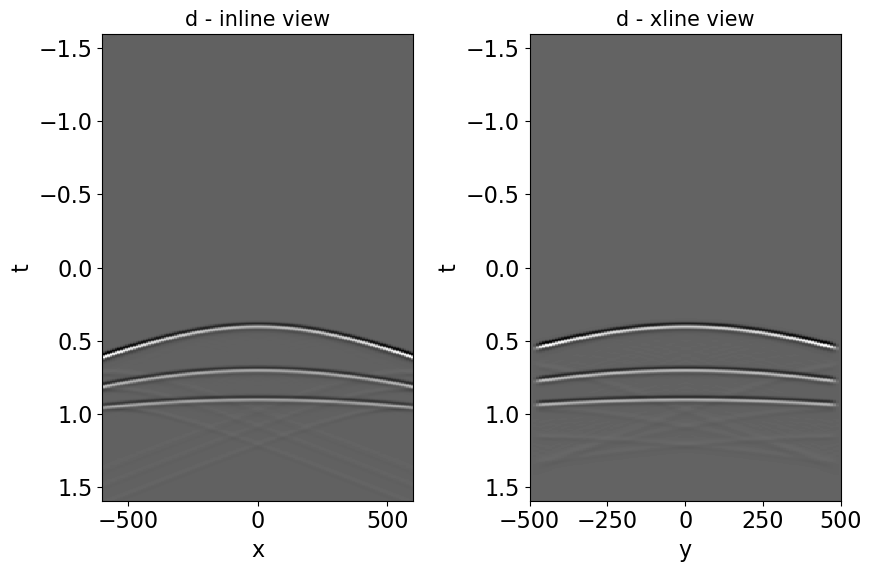

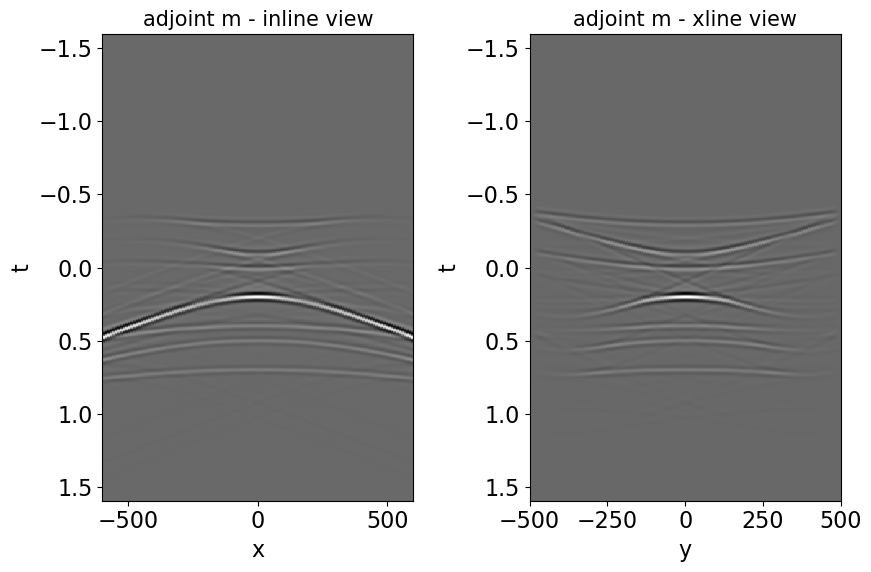

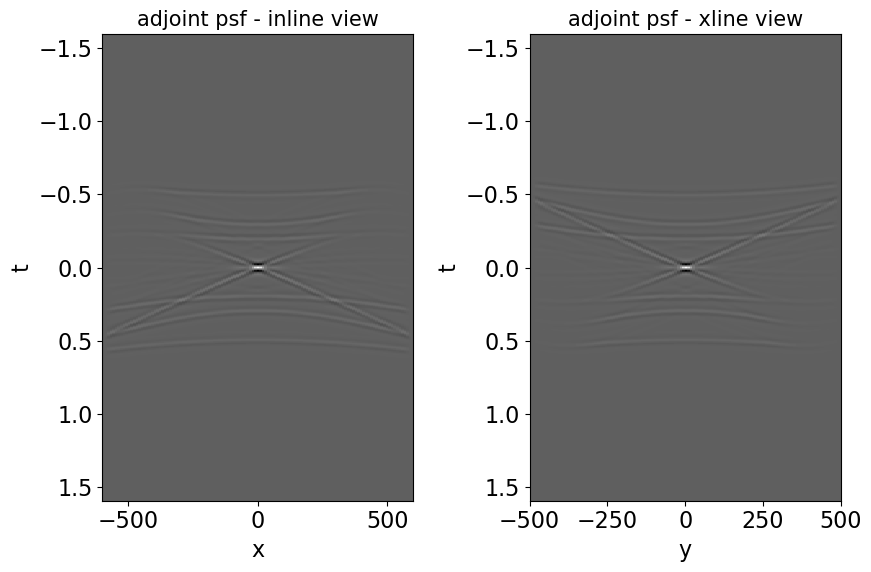

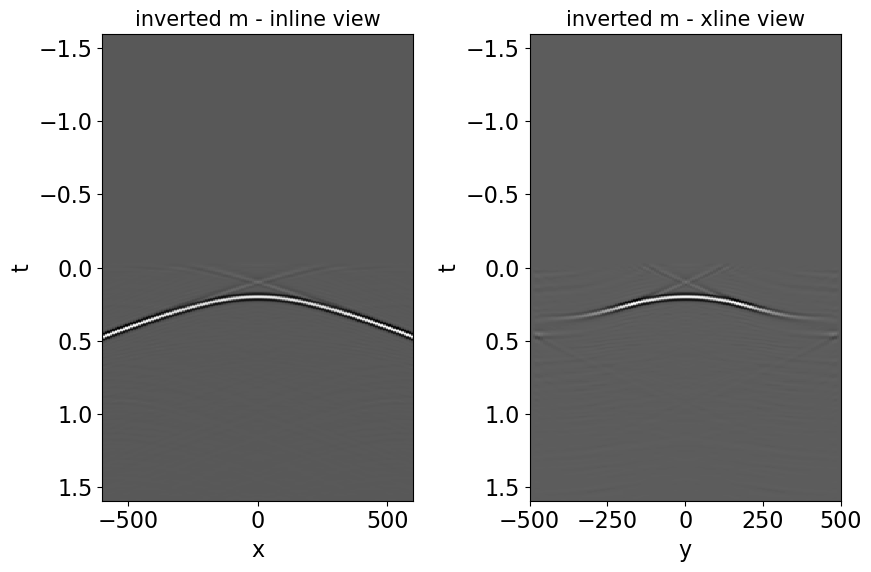

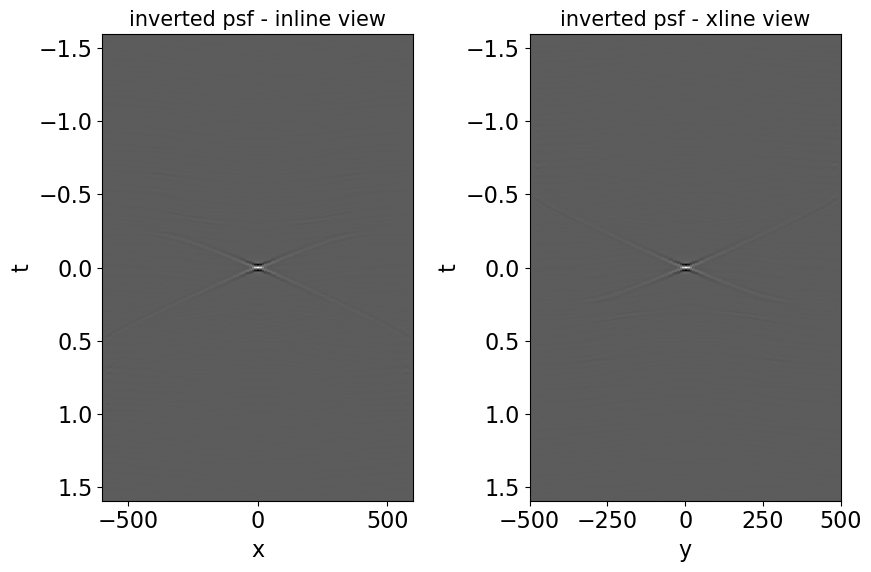

In [14]:
# Plotting
plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(mwav[:,int(par['nx']/2),:].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(d[:, int(par['ny']/2)],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(d[:, :,int(par['nx']/2)],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(madj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(madj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(psfadj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint psf - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(psfadj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint psf - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(minv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(minv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(psfinv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted psf - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(psfinv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted psf - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

In [15]:
# Invert for model (cupy)
minv,madj = MDD(cp.array(Gwav2), cp.array(d).transpose(1, 2, 0), dt=par['dt'], dr=par['dx'], 
                nfmax=par['nfmax'], twosided=True, wav=cp.array(wav), 
                causality_precond=True, smooth_precond=5,
                adjoint=True, add_negative=False, psf=False,
                dottest=True, **dict(engine='pylops', damp=1e-10, niter=30, show=1))

Dot test passed, v^H(Opu)=-72453.40343736071 - u^H(Op^Hv)=-72453.40343736083
PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 9764579 rows and 11698159 cols
Prec=<11698159x11698159 Diagonal with dtype=float64>
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 9764579 rows and 11698159 cols
damp = 1.000000e-20	tol = 1.000000e-04	niter = 30
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         2.3547e+03     2.3547e+03
     2        0.0000e+00         1.6112e+03     1.6112e+03
     3        0.0000e+00         1.1797e+03     1.1797e+03
     4        0.0000e+00         9.3171e+02     9.3171e+02
     5        0.0000e+00         7.7041e+02     7.7041e+02
     6        0.0000e+00         6.4975e+02     6.4975e+02
     7       

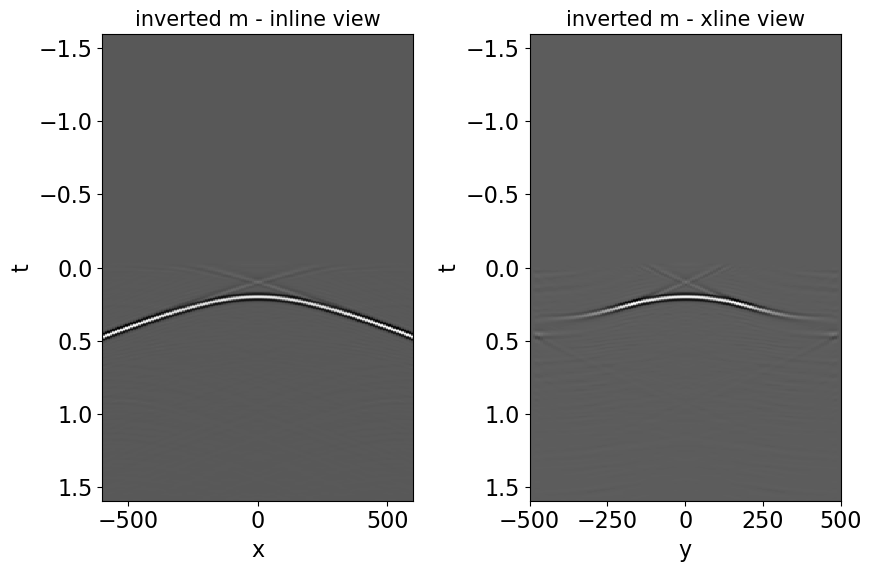

In [16]:
plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(cp.asnumpy(minv)[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(cp.asnumpy(minv)[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

In [17]:
%timeit -n1 -r1 MDD(Gwav2, d.transpose(1, 2, 0), dt=par['dt'], dr=par['dx'],  nfmax=par['nfmax'], twosided=True, wav=wav, add_negative=False, **dict(damp=1e-10, iter_lim=30, show=0))
%timeit -n1 -r1 MDD(cp.array(Gwav2), cp.array(d).transpose(1, 2, 0), dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], twosided=True, wav=cp.array(wav), add_negative=False, **dict(damp=1e-10, niter=30, show=0))

1min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
